<a href="https://colab.research.google.com/github/betultgumus/GooglePlayStore2018/blob/main/GooglePlayStore2018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Google Play Store 2018 Uygulama Verileri Analizi
Bu çalışma, 2018 yılına ait Google Play Store verilerini kullanarak Android uygulama pazarındaki trendleri ve kullanıcı davranışlarını anlamayı amaçlamaktadır.

Analizin temel hedefleri şunlardır:
* En popüler uygulama kategorilerini belirlemek.
* Ücretli ve ücretsiz uygulamaların indirilme oranlarını karşılaştırmak.
* Kategorilere göre uygulamaların indirilme ve etkileşim oranını incelemek.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

url = 'https://drive.google.com/uc?export=download&id=1PN91MOiRxA3nnZIixwQmqv4xRZcY-TD8'
df = pd.read_csv(url)

df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


---
##1. Veri Setinin Tanınması (Data Understanding):

In [2]:
df.shape

(10841, 13)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


In [4]:
df.describe()

,Rating
count,9367.000000
mean,4.193338
std,0.537431
min,1.000000
25%,4.000000
50%,4.300000
75%,4.500000
max,19.000000



`info()` ve `describe()` çıktıları ile veri setinin yapısal özellikleri incelenmiştir. Yapılan analizde şu kritik bulgulara ulaşılmıştır:

1.  **Veri Tipi Uyuşmazlığı:** Analiz için kritik öneme sahip olan `Reviews`, `Size`, `Installs` ve `Price` sütunları sayısal (`int/float`) değil, `object` (metin) tipinde olduğu görülmüştür. `Last Updated` bir tarih belirttiği için `Date` tipide olmalıdır.
2. **Eksik Veri Tespiti:** Veri seti incelendiğinde; `Rating`, `Type`, `Content Rating`, `Current Ver` ve `Android Ver `sütunlarında eksik değerler (missing values) olduğu tespit edilmiştir. Özellikle Rating sütununda eksik veri miktarının diğerlerine göre belirgin şekilde yüksek olduğu görülmektedir.

---
##2. Veri Temizliği ve Veri Tipi Dönüşümleri (Data Cleaning and  Type Conversion):

**`Reviews`:** Numeric olmayan değerler temizlendi ve uygun veri tipine `(float)` çevrildi.

In [5]:
print(df[~df['Reviews'].str.isnumeric()]['Reviews'].unique())


['3.0M']


In [6]:
df[df['Reviews'] == '3.0M']

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
10472,Life Made WI-Fi Touchscreen Photo Frame,1.9,19.0,3.0M,"1,000+",Free,0,Everyone,NaN,"February 11, 2018",1.0.19,4.0 and up,NaN


In [7]:
df = df[df['Reviews'] != '3.0M']

In [8]:
df['Reviews'] = pd.to_numeric(df['Reviews'], errors='coerce')

In [9]:
df.describe()

,Rating,Reviews
count,9366.000000,1.084000e+04
mean,4.191757,4.441529e+05
std,0.515219,2.927761e+06
min,1.000000,0.000000e+00
25%,4.000000,3.800000e+01
50%,4.300000,2.094000e+03
75%,4.500000,5.477550e+04
max,5.000000,7.815831e+07


**`Size`:** Sütunundaki 'M' (Megabayt) ve 'k' (Kilabayt) gibi metin tabanlı birim ifadeleri temizlendi. Gerekli katsayı çarpanları uygulanarak tüm veriler standart sayısal birime `(float)` dönüştürüldü. 'Varies with device' gibi sayısal olmayan ifadeler `NaN` olarak ayarlanır.

In [10]:
print(df[~df['Size'].str.isnumeric()]['Size'].unique())


['19M' '14M' '8.7M' '25M' '2.8M' '5.6M' '29M' '33M' '3.1M' '28M' '12M'
 '20M' '21M' '37M' '2.7M' '5.5M' '17M' '39M' '31M' '4.2M' '7.0M' '23M'
 '6.0M' '6.1M' '4.6M' '9.2M' '5.2M' '11M' '24M' 'Varies with device'
 '9.4M' '15M' '10M' '1.2M' '26M' '8.0M' '7.9M' '56M' '57M' '35M' '54M'
 '201k' '3.6M' '5.7M' '8.6M' '2.4M' '27M' '2.5M' '16M' '3.4M' '8.9M'
 '3.9M' '2.9M' '38M' '32M' '5.4M' '18M' '1.1M' '2.2M' '4.5M' '9.8M' '52M'
 '9.0M' '6.7M' '30M' '2.6M' '7.1M' '3.7M' '22M' '7.4M' '6.4M' '3.2M'
 '8.2M' '9.9M' '4.9M' '9.5M' '5.0M' '5.9M' '13M' '73M' '6.8M' '3.5M'
 '4.0M' '2.3M' '7.2M' '2.1M' '42M' '7.3M' '9.1M' '55M' '23k' '6.5M' '1.5M'
 '7.5M' '51M' '41M' '48M' '8.5M' '46M' '8.3M' '4.3M' '4.7M' '3.3M' '40M'
 '7.8M' '8.8M' '6.6M' '5.1M' '61M' '66M' '79k' '8.4M' '118k' '44M' '695k'
 '1.6M' '6.2M' '18k' '53M' '1.4M' '3.0M' '5.8M' '3.8M' '9.6M' '45M' '63M'
 '49M' '77M' '4.4M' '4.8M' '70M' '6.9M' '9.3M' '10.0M' '8.1M' '36M' '84M'
 '97M' '2.0M' '1.9M' '1.8M' '5.3M' '47M' '556k' '526k' '76M' '7.6M'

In [11]:
def size_to_megabytes(size):
    if pd.isnull(size):
        return np.nan

    str_size = str(size)

    if 'M' in str_size:
        return float(str_size.replace('M', ''))

    elif 'k' in str_size:
        return float(str_size.replace('k', '')) / 1000

    elif 'Varies with device' in str_size:
        return np.nan

    else:
        try:
            return float(str_size)
        except:
            return np.nan

if 'Size' in df.columns:
    df['Size_MB'] = df['Size'].apply(size_to_megabytes)
    df.drop('Size', axis=1, inplace=True)
elif 'Size_MB' in df.columns:
    df['Size_MB'] = df['Size_MB'].apply(size_to_megabytes)
else:
    print("Hata: 'Size' veya 'Size_MB' sütunu bulunamadı.")


In [12]:
df.describe()

,Rating,Reviews,Size_MB
count,9366.000000,1.084000e+04,9145.000000
mean,4.191757,4.441529e+05,21.516530
std,0.515219,2.927761e+06,22.588748
min,1.000000,0.000000e+00,0.008500
25%,4.000000,3.800000e+01,4.900000
50%,4.300000,2.094000e+03,13.000000
75%,4.500000,5.477550e+04,30.000000
max,5.000000,7.815831e+07,100.000000


**`Installs`:** Sayısal olmayan karakterler temizlendi ve analiz süreçlerine uygun hale getirilmek üzere `int` veri tipine dönüştürüldü.

In [13]:
print(df[~df['Installs'].str.isnumeric()]['Installs'].unique())


['10,000+' '500,000+' '5,000,000+' '50,000,000+' '100,000+' '50,000+'
 '1,000,000+' '10,000,000+' '5,000+' '100,000,000+' '1,000,000,000+'
 '1,000+' '500,000,000+' '50+' '100+' '500+' '10+' '1+' '5+' '0+']


In [14]:
print(df['Installs'].value_counts())

Installs
1,000,000+        1579
10,000,000+       1252
100,000+          1169
10,000+           1054
1,000+             907
5,000,000+         752
100+               719
500,000+           539
50,000+            479
5,000+             477
100,000,000+       409
10+                386
500+               330
50,000,000+        289
50+                205
5+                  82
500,000,000+        72
1+                  67
1,000,000,000+      58
0+                  14
0                    1
Name: count, dtype: int64


In [15]:
def clean_installs(installs_value):
    if pd.isnull(installs_value):
        return np.nan

    str_installs = str(installs_value)

    str_installs = str_installs.replace('+', '')
    str_installs = str_installs.replace(',', '')

    try:
        return int(str_installs)
    except:
        return np.nan

df['Installs'] = df['Installs'].apply(clean_installs)


In [16]:
df.describe()

,Rating,Reviews,Installs,Size_MB
count,9366.000000,1.084000e+04,1.084000e+04,9145.000000
mean,4.191757,4.441529e+05,1.546434e+07,21.516530
std,0.515219,2.927761e+06,8.502936e+07,22.588748
min,1.000000,0.000000e+00,0.000000e+00,0.008500
25%,4.000000,3.800000e+01,1.000000e+03,4.900000
50%,4.300000,2.094000e+03,1.000000e+05,13.000000
75%,4.500000,5.477550e+04,5.000000e+06,30.000000
max,5.000000,7.815831e+07,1.000000e+09,100.000000


**`Type`**

In [17]:
print(df['Type'].value_counts())

Type
Free    10039
Paid      800
Name: count, dtype: int64


**`Price`:** Sayısal olmayan birim belirten karakterler temizlendi ve analiz süreçlerine uygun hale getirilmek üzere `float` veri tipine dönüştürüldü.

In [18]:
print(df[~df['Price'].str.isnumeric()]['Price'].unique())


['$4.99' '$3.99' '$6.99' '$1.49' '$2.99' '$7.99' '$5.99' '$3.49' '$1.99'
 '$9.99' '$7.49' '$0.99' '$9.00' '$5.49' '$10.00' '$24.99' '$11.99'
 '$79.99' '$16.99' '$14.99' '$1.00' '$29.99' '$12.99' '$2.49' '$10.99'
 '$1.50' '$19.99' '$15.99' '$33.99' '$74.99' '$39.99' '$3.95' '$4.49'
 '$1.70' '$8.99' '$2.00' '$3.88' '$25.99' '$399.99' '$17.99' '$400.00'
 '$3.02' '$1.76' '$4.84' '$4.77' '$1.61' '$2.50' '$1.59' '$6.49' '$1.29'
 '$5.00' '$13.99' '$299.99' '$379.99' '$37.99' '$18.99' '$389.99' '$19.90'
 '$8.49' '$1.75' '$14.00' '$4.85' '$46.99' '$109.99' '$154.99' '$3.08'
 '$2.59' '$4.80' '$1.96' '$19.40' '$3.90' '$4.59' '$15.46' '$3.04' '$4.29'
 '$2.60' '$3.28' '$4.60' '$28.99' '$2.95' '$2.90' '$1.97' '$200.00'
 '$89.99' '$2.56' '$30.99' '$3.61' '$394.99' '$1.26' '$1.20' '$1.04']


In [19]:
def clean_price(price_value):
    if pd.isnull(price_value):
        return np.nan

    str_price = str(price_value)

    str_price = str_price.replace('$', '')

    try:
        return float(str_price)
    except:
        return np.nan

df['Price_$'] = df['Price'].apply(clean_price)
df.drop('Price', axis=1, inplace=True)

In [20]:
print(df['Price_$'].value_counts())

Price_$
0.00      10040
0.99        148
2.99        129
1.99         73
4.99         72
          ...  
3.61          1
394.99        1
1.26          1
1.20          1
1.04          1
Name: count, Length: 92, dtype: int64


In [21]:
df.describe()

,Rating,Reviews,Installs,Size_MB,Price_$
count,9366.000000,1.084000e+04,1.084000e+04,9145.000000,10840.000000
mean,4.191757,4.441529e+05,1.546434e+07,21.516530,1.027368
std,0.515219,2.927761e+06,8.502936e+07,22.588748,15.949703
min,1.000000,0.000000e+00,0.000000e+00,0.008500,0.000000
25%,4.000000,3.800000e+01,1.000000e+03,4.900000,0.000000
50%,4.300000,2.094000e+03,1.000000e+05,13.000000,0.000000
75%,4.500000,5.477550e+04,5.000000e+06,30.000000,0.000000
max,5.000000,7.815831e+07,1.000000e+09,100.000000,400.000000


**`Last Updated`:** Veri tipi date formatına dönüştürüldü.

In [22]:
df['Last Updated'] = pd.to_datetime(df['Last Updated'])

In [23]:
df.sort_values(by='Last Updated', ascending=False, inplace=True)
display(df.head())

,App,Category,Rating,Reviews,Installs,Type,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Size_MB,Price_$
10712,Lalafo Pulsuz Elanlar,SHOPPING,4.4,61392,1000000,Free,Everyone,Shopping,2018-08-08,Varies with device,Varies with device,NaN,0.00
10209,Video Downloader For FB: Save FB Videos 2018,TOOLS,4.3,434,50000,Free,Everyone,Tools,2018-08-08,1.1.9,4.0.3 and up,3.6,0.00
10408,Shoot Hunter-Gun Killer,GAME,4.3,320334,50000000,Free,Teen,Action,2018-08-08,1.1.2,4.1 and up,27.0,0.00
10718,BankNordik,FINANCE,3.9,28,5000,Free,Everyone,Finance,2018-08-08,7.3.2,5.0 and up,15.0,0.00
10760,Fast Tract Diet,HEALTH_AND_FITNESS,4.4,35,1000,Paid,Everyone,Health & Fitness,2018-08-08,1.9.3,4.2 and up,2.4,7.99


In [24]:
df['Last_Updated_Day'] = df['Last Updated'].dt.day
df['Last_Updated_Month'] = df['Last Updated'].dt.month
df['Last_Updated_Year'] = df['Last Updated'].dt.year

display(df.head())

,App,Category,Rating,Reviews,Installs,Type,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Size_MB,Price_$,Last_Updated_Day,Last_Updated_Month,Last_Updated_Year
10712,Lalafo Pulsuz Elanlar,SHOPPING,4.4,61392,1000000,Free,Everyone,Shopping,2018-08-08,Varies with device,Varies with device,NaN,0.00,8,8,2018
10209,Video Downloader For FB: Save FB Videos 2018,TOOLS,4.3,434,50000,Free,Everyone,Tools,2018-08-08,1.1.9,4.0.3 and up,3.6,0.00,8,8,2018
10408,Shoot Hunter-Gun Killer,GAME,4.3,320334,50000000,Free,Teen,Action,2018-08-08,1.1.2,4.1 and up,27.0,0.00,8,8,2018
10718,BankNordik,FINANCE,3.9,28,5000,Free,Everyone,Finance,2018-08-08,7.3.2,5.0 and up,15.0,0.00,8,8,2018
10760,Fast Tract Diet,HEALTH_AND_FITNESS,4.4,35,1000,Paid,Everyone,Health & Fitness,2018-08-08,1.9.3,4.2 and up,2.4,7.99,8,8,2018


In [25]:
df.describe()

,Rating,Reviews,Installs,Last Updated,Size_MB,Price_$,Last_Updated_Day,Last_Updated_Month,Last_Updated_Year
count,9366.000000,1.084000e+04,1.084000e+04,10840,9145.000000,10840.000000,10840.000000,10840.000000,10840.000000
mean,4.191757,4.441529e+05,1.546434e+07,2017-11-21 06:43:02.435424256,21.516530,1.027368,15.609041,6.422325,2017.399723
min,1.000000,0.000000e+00,0.000000e+00,2010-05-21 00:00:00,0.008500,0.000000,1.000000,1.000000,2010.000000
25%,4.000000,3.800000e+01,1.000000e+03,2017-09-20 00:00:00,4.900000,0.000000,6.000000,5.000000,2017.000000
50%,4.300000,2.094000e+03,1.000000e+05,2018-05-24 00:00:00,13.000000,0.000000,16.000000,7.000000,2018.000000
75%,4.500000,5.477550e+04,5.000000e+06,2018-07-20 00:00:00,30.000000,0.000000,24.000000,8.000000,2018.000000
max,5.000000,7.815831e+07,1.000000e+09,2018-08-08 00:00:00,100.000000,400.000000,31.000000,12.000000,2018.000000
std,0.515219,2.927761e+06,8.502936e+07,NaN,22.588748,15.949703,9.561621,2.578388,1.100914


**`Current Ver`:** Versiyon numaralarını sıralamak için veriler ayrıştırılarak `tuple` yapısına dönüştürüldü.

In [26]:
import re

def version_to_tuple(ver):
    try:
        if pd.isnull(ver) or 'Varies with device' in str(ver):
            return None

        clean_ver = str(ver).split()[0]

        parts = clean_ver.split('.')

        numeric_parts = []
        for part in parts:
            num_str = re.sub(r'\D', '', part)
            if num_str:
                numeric_parts.append(int(num_str))
            else:
                numeric_parts.append(0)

        return tuple(numeric_parts)

    except:
        return None

if 'Current Ver' in df.columns:
    df['Current_Ver_Tuple'] = df['Current Ver'].apply(version_to_tuple)
    df.drop('Current Ver', axis=1, inplace=True)
else:
    print("'Current Ver' sütunu zaten mevcut değil.")


In [27]:
df['Current_Ver_Tuple'].unique()

array([None, (1, 1, 9), (1, 1, 2), ..., (1, 3, 3, 9), (0, 6, 11), (0, 59)],
      dtype=object)

In [28]:
print(df['Current_Ver_Tuple'].value_counts())

Current_Ver_Tuple
(1, 0)           822
(1, 1)           284
(1, 2)           192
(1, 3)           161
(2, 0)           151
                ... 
(6, 71)            1
(1, 5, 447)        1
(4, 6, 2, 0)       1
(2, 8, 0, 17)      1
(4, 70)            1
Name: count, Length: 2573, dtype: int64


In [29]:
df.head()

,App,Category,Rating,Reviews,Installs,Type,Content Rating,Genres,Last Updated,Android Ver,Size_MB,Price_$,Last_Updated_Day,Last_Updated_Month,Last_Updated_Year,Current_Ver_Tuple
10712,Lalafo Pulsuz Elanlar,SHOPPING,4.4,61392,1000000,Free,Everyone,Shopping,2018-08-08,Varies with device,NaN,0.00,8,8,2018,None
10209,Video Downloader For FB: Save FB Videos 2018,TOOLS,4.3,434,50000,Free,Everyone,Tools,2018-08-08,4.0.3 and up,3.6,0.00,8,8,2018,"(1, 1, 9)"
10408,Shoot Hunter-Gun Killer,GAME,4.3,320334,50000000,Free,Teen,Action,2018-08-08,4.1 and up,27.0,0.00,8,8,2018,"(1, 1, 2)"
10718,BankNordik,FINANCE,3.9,28,5000,Free,Everyone,Finance,2018-08-08,5.0 and up,15.0,0.00,8,8,2018,"(7, 3, 2)"
10760,Fast Tract Diet,HEALTH_AND_FITNESS,4.4,35,1000,Paid,Everyone,Health & Fitness,2018-08-08,4.2 and up,2.4,7.99,8,8,2018,"(1, 9, 3)"


**`Android Ver`:** Versiyon numaralarını sıralamak için veriler ayrıştırılarak `tuple` yapısına dönüştürüldü.

In [30]:
import re

def version_to_tuple(ver):
    try:
        if pd.isnull(ver) or 'Varies with device' in str(ver):
            return None

        clean_ver = str(ver).split()[0]

        parts = clean_ver.split('.')

        numeric_parts = []
        for part in parts:
            num_str = re.sub(r'\D', '', part)
            if num_str:
                numeric_parts.append(int(num_str))
            else:
                numeric_parts.append(0)

        return tuple(numeric_parts)

    except:
        return None

df['Android_Ver_Tuple'] = df['Android Ver'].apply(version_to_tuple)
df.drop('Android Ver', axis=1, inplace=True)


In [31]:
df['Android_Ver_Tuple'].unique()

array([None, (4, 0, 3), (4, 1), (5, 0), (4, 2), (4, 4), (2, 3), (4, 3),
       (4, 0), (1, 6), (1, 0), (1, 5), (6, 0), (7, 0), (2, 2), (8, 0),
       (3, 0), (5, 1), (2, 3, 3), (3, 2), (2, 1), (7, 1), (2, 0),
       (2, 0, 1), (3, 1)], dtype=object)

In [32]:
print(df['Android_Ver_Tuple'].value_counts())

Android_Ver_Tuple
(4, 1)       2452
(4, 0, 3)    1503
(4, 0)       1375
(4, 4)        992
(2, 3)        652
(5, 0)        605
(4, 2)        394
(2, 3, 3)     281
(2, 2)        245
(4, 3)        243
(3, 0)        241
(2, 1)        134
(1, 6)        116
(6, 0)         60
(7, 0)         43
(3, 2)         36
(2, 0)         32
(5, 1)         24
(1, 5)         20
(3, 1)         10
(2, 0, 1)       7
(8, 0)          6
(7, 1)          3
(1, 0)          2
Name: count, dtype: int64


In [33]:
df.head()

,App,Category,Rating,Reviews,Installs,Type,Content Rating,Genres,Last Updated,Size_MB,Price_$,Last_Updated_Day,Last_Updated_Month,Last_Updated_Year,Current_Ver_Tuple,Android_Ver_Tuple
10712,Lalafo Pulsuz Elanlar,SHOPPING,4.4,61392,1000000,Free,Everyone,Shopping,2018-08-08,NaN,0.00,8,8,2018,None,None
10209,Video Downloader For FB: Save FB Videos 2018,TOOLS,4.3,434,50000,Free,Everyone,Tools,2018-08-08,3.6,0.00,8,8,2018,"(1, 1, 9)","(4, 0, 3)"
10408,Shoot Hunter-Gun Killer,GAME,4.3,320334,50000000,Free,Teen,Action,2018-08-08,27.0,0.00,8,8,2018,"(1, 1, 2)","(4, 1)"
10718,BankNordik,FINANCE,3.9,28,5000,Free,Everyone,Finance,2018-08-08,15.0,0.00,8,8,2018,"(7, 3, 2)","(5, 0)"
10760,Fast Tract Diet,HEALTH_AND_FITNESS,4.4,35,1000,Paid,Everyone,Health & Fitness,2018-08-08,2.4,7.99,8,8,2018,"(1, 9, 3)","(4, 2)"


---
##3. Tekrarlayan Verilerin Kaldırılması (Handling Duplicates):
Veri setindeki uygulamaların 'App' adı ve 'Category'si aynı olan satırları, tekrar eden girişler olarak kabul edip kaldırıyoruz. Bu işlem, veri tutarlılığını sağlamak ve analizlerimizi daha doğru hale getirmek için önemlidir.

In [34]:
print(f"Tekrarlayan veriler silinmeden önceki DataFrame boyutu: {df.shape}")

df.drop_duplicates(subset=['App', 'Category'], inplace=True)

print(f"Tekrarlayan veriler silindikten sonraki DataFrame boyutu: {df.shape}")

Tekrarlayan veriler silinmeden önceki DataFrame boyutu: (10840, 16)
Tekrarlayan veriler silindikten sonraki DataFrame boyutu: (9744, 16)


In [35]:
df.head()

,App,Category,Rating,Reviews,Installs,Type,Content Rating,Genres,Last Updated,Size_MB,Price_$,Last_Updated_Day,Last_Updated_Month,Last_Updated_Year,Current_Ver_Tuple,Android_Ver_Tuple
10712,Lalafo Pulsuz Elanlar,SHOPPING,4.4,61392,1000000,Free,Everyone,Shopping,2018-08-08,NaN,0.00,8,8,2018,None,None
10209,Video Downloader For FB: Save FB Videos 2018,TOOLS,4.3,434,50000,Free,Everyone,Tools,2018-08-08,3.6,0.00,8,8,2018,"(1, 1, 9)","(4, 0, 3)"
10408,Shoot Hunter-Gun Killer,GAME,4.3,320334,50000000,Free,Teen,Action,2018-08-08,27.0,0.00,8,8,2018,"(1, 1, 2)","(4, 1)"
10718,BankNordik,FINANCE,3.9,28,5000,Free,Everyone,Finance,2018-08-08,15.0,0.00,8,8,2018,"(7, 3, 2)","(5, 0)"
10760,Fast Tract Diet,HEALTH_AND_FITNESS,4.4,35,1000,Paid,Everyone,Health & Fitness,2018-08-08,2.4,7.99,8,8,2018,"(1, 9, 3)","(4, 2)"


##4. Eksik Verilerin Giderilmesi (Missing Value Handling):
`Rating`, `Size_MB`, `Type`, `Current_Ver_Tuple` ve `Android_Ver_Tuple` sütunlarında eksik veriler tespit edildi.

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9744 entries, 10712 to 7479
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   App                 9744 non-null   object        
 1   Category            9744 non-null   object        
 2   Rating              8280 non-null   float64       
 3   Reviews             9744 non-null   int64         
 4   Installs            9744 non-null   int64         
 5   Type                9743 non-null   object        
 6   Content Rating      9744 non-null   object        
 7   Genres              9744 non-null   object        
 8   Last Updated        9744 non-null   datetime64[ns]
 9   Size_MB             8493 non-null   float64       
 10  Price_$             9744 non-null   float64       
 11  Last_Updated_Day    9744 non-null   int32         
 12  Last_Updated_Month  9744 non-null   int32         
 13  Last_Updated_Year   9744 non-null   int32        

`Size_MB`: Uygulamaların boyutları kategorilere göre değişkenlik gösterebilir. Bu yüzden NaN değerler kategorilere göre dağılımı dengeleyecek şekilde dolmalı. Ortalama kullanmamız veri setindeki yığılmalar bu dengeyi bozabilir o üzden medyan değerini kullanıldı.

In [37]:
category_median_size = df.groupby('Category')['Size_MB'].median()
print('Median Size_MB by Category:')
print(category_median_size)

df['Size_MB'] = df.groupby('Category')['Size_MB'].transform(lambda x: x.fillna(x.median()))

Median Size_MB by Category:
Category
ART_AND_DESIGN          8.95
AUTO_AND_VEHICLES      16.00
BEAUTY                  9.20
BOOKS_AND_REFERENCE     7.35
BUSINESS                8.60
COMICS                 10.00
COMMUNICATION           5.70
DATING                 11.00
EDUCATION              15.00
ENTERTAINMENT          18.50
EVENTS                  9.70
FAMILY                 19.00
FINANCE                12.00
FOOD_AND_DRINK         17.00
GAME                   38.00
HEALTH_AND_FITNESS     11.00
HOUSE_AND_HOME          9.45
LIBRARIES_AND_DEMO      3.10
LIFESTYLE               9.60
MAPS_AND_NAVIGATION     9.80
MEDICAL                15.00
NEWS_AND_MAGAZINES      9.00
PARENTING              11.00
PERSONALIZATION         7.10
PHOTOGRAPHY             9.65
PRODUCTIVITY            6.90
SHOPPING               12.00
SOCIAL                  7.90
SPORTS                 20.00
TOOLS                   4.20
TRAVEL_AND_LOCAL       18.00
VIDEO_PLAYERS           8.00
WEATHER                 9.20
Name: 

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9744 entries, 10712 to 7479
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   App                 9744 non-null   object        
 1   Category            9744 non-null   object        
 2   Rating              8280 non-null   float64       
 3   Reviews             9744 non-null   int64         
 4   Installs            9744 non-null   int64         
 5   Type                9743 non-null   object        
 6   Content Rating      9744 non-null   object        
 7   Genres              9744 non-null   object        
 8   Last Updated        9744 non-null   datetime64[ns]
 9   Size_MB             9744 non-null   float64       
 10  Price_$             9744 non-null   float64       
 11  Last_Updated_Day    9744 non-null   int32         
 12  Last_Updated_Month  9744 non-null   int32         
 13  Last_Updated_Year   9744 non-null   int32        

`Type:` Eksik veri sadece 1 satırdır. Veri satırı silinebilir ya da dağılımı etkilemeyecek şekilde mod ile doldurulabilir. Burada mod ile doldurma işlemi yapıldı.

In [39]:
mode_type = df['Type'].mode()[0]
df['Type'].fillna(mode_type, inplace=True)
print(f"'Type' sütunundaki eksik değerler '{mode_type}' ile dolduruldu.")

'Type' sütunundaki eksik değerler 'Free' ile dolduruldu.


/tmp/ipython-input-1160552514.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Type'].fillna(mode_type, inplace=True)


In [40]:
print(df['Type'].value_counts())

Type
Free    8987
Paid     757
Name: count, dtype: int64


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9744 entries, 10712 to 7479
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   App                 9744 non-null   object        
 1   Category            9744 non-null   object        
 2   Rating              8280 non-null   float64       
 3   Reviews             9744 non-null   int64         
 4   Installs            9744 non-null   int64         
 5   Type                9744 non-null   object        
 6   Content Rating      9744 non-null   object        
 7   Genres              9744 non-null   object        
 8   Last Updated        9744 non-null   datetime64[ns]
 9   Size_MB             9744 non-null   float64       
 10  Price_$             9744 non-null   float64       
 11  Last_Updated_Day    9744 non-null   int32         
 12  Last_Updated_Month  9744 non-null   int32         
 13  Last_Updated_Year   9744 non-null   int32        

`Current_Ver_Tuple:`Sıralama işlemi yapabilmek için tuple formatına çevirmiştik. Bu yüzden ortalama değerini kullanamayız. Mod değerini de versiyon numaraları uygulamalara özel olduğu için kullanamayız. Bu yüzden NaN değerlerine `(0,0,0)` değer ataması yaparak eksik veriyi tamamladık.

In [42]:
df['Current_Ver_Tuple'] = df['Current_Ver_Tuple'].apply(lambda x: (0,0,0) if x is None else x)

In [43]:
print(df['Current_Ver_Tuple'].value_counts())

Current_Ver_Tuple
(0, 0, 0)       1080
(1, 0)           810
(1, 1)           280
(1, 2)           190
(1, 3)           156
                ... 
(2, 1, 0, 9)       1
(1, 2, 10)         1
(3, 69, 0)         1
(6, 71)            1
(1, 5, 447)        1
Name: count, Length: 2568, dtype: int64


`Android_Ver_Tuple:` Sıralama işlemi yapabilmek için tuple formatına çevirmiştik. Bu yüzden ortalama değerini kullanamayız. Mod değerini de versiyon numaraları uygulamalara özel olduğu için kullanamayız. Bu yüzden NaN değerlerine `(0,0,0)` değer ataması yaparak eksik veriyi tamamladık.

In [44]:
df['Android_Ver_Tuple'] = df['Android_Ver_Tuple'].apply(lambda x: (0,0,0) if x is None else x)

In [45]:
print(df['Android_Ver_Tuple'].value_counts())

Android_Ver_Tuple
(4, 1)       2236
(4, 0, 3)    1406
(4, 0)       1290
(0, 0, 0)    1009
(4, 4)        839
(2, 3)        623
(5, 0)        520
(4, 2)        372
(2, 3, 3)     274
(2, 2)        240
(3, 0)        229
(4, 3)        222
(2, 1)        133
(1, 6)        116
(6, 0)         54
(7, 0)         43
(3, 2)         36
(2, 0)         32
(5, 1)         22
(1, 5)         20
(3, 1)         10
(2, 0, 1)       7
(8, 0)          6
(7, 1)          3
(1, 0)          2
Name: count, dtype: int64


`Rating:`Bu sütun diğer sütunlar gibi değil, çok fazla etkene bağlı. Sadece mod, medyan, ortalama gibi değerleri yazmak yetmez.

Silersek verinin büyük bir kısmını kaybolacak. Bu yüzden uygun şekilde doldurulmalı.

Aslında bu sütundaki NaN değerleri doldurmak için makine öğrenmesi kullanmak en mantıklısı fakat kırılımlı doldurma sütunlarına uygulandı ve veri bozulmadan boşluklarından kurtuldu.



In [46]:
df['Install_Group'] = pd.cut(df['Installs'],
                             bins=[-1, 1000, 100000, 1000000, np.inf],
                             labels=['Low', 'Medium', 'High', 'Very_High'])

df['Rating'] = df['Rating'].fillna(
    df.groupby(['Category', 'Type', 'Install_Group'])['Rating'].transform('median'))

df['Rating'] = df['Rating'].fillna(
    df.groupby(['Category', 'Type'])['Rating'].transform('median'))

df['Rating'] = df['Rating'].fillna(
    df.groupby('Category')['Rating'].transform('median'))

df['Rating'] = df['Rating'].fillna(df['Rating'].median())

df.drop('Install_Group', axis=1, inplace=True)

print("Kalan boş Rating sayısı:", df['Rating'].isna().sum())

Kalan boş Rating sayısı: 0


/tmp/ipython-input-4026675239.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(['Category', 'Type', 'Install_Group'])['Rating'].transform('median'))


In [47]:

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9744 entries, 10712 to 7479
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   App                 9744 non-null   object        
 1   Category            9744 non-null   object        
 2   Rating              9744 non-null   float64       
 3   Reviews             9744 non-null   int64         
 4   Installs            9744 non-null   int64         
 5   Type                9744 non-null   object        
 6   Content Rating      9744 non-null   object        
 7   Genres              9744 non-null   object        
 8   Last Updated        9744 non-null   datetime64[ns]
 9   Size_MB             9744 non-null   float64       
 10  Price_$             9744 non-null   float64       
 11  Last_Updated_Day    9744 non-null   int32         
 12  Last_Updated_Month  9744 non-null   int32         
 13  Last_Updated_Year   9744 non-null   int32        

---
##4. Keşifçi Veri Analizi (EDA & Visualization):

###Numeric Değişkenlerin Dağılım Grafiği

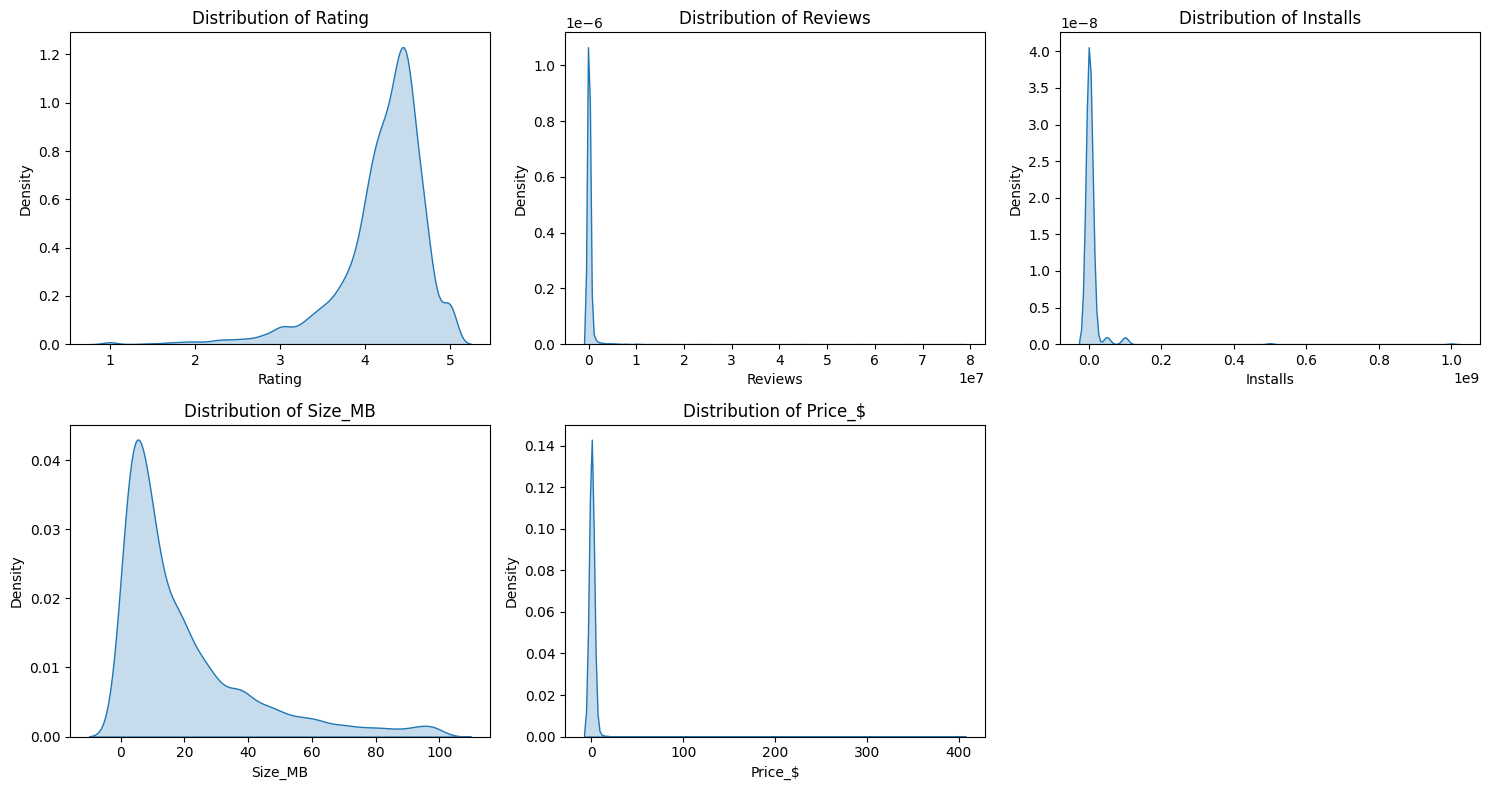

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

num_numeric_cols = len(numeric_cols)
num_cols = 3
num_rows = (num_numeric_cols + num_cols - 1) // num_cols

plt.figure(figsize=(num_cols * 5, num_rows * 4))

for i, col in enumerate(numeric_cols):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.kdeplot(df[col], fill=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Density')

plt.tight_layout()
plt.show()

### 'Reviews' ve 'Installs' Sütunlarının Logaritmik Ölçekte Dağılımı

'Reviews' ve 'Installs' sütunlarındaki değerler arasında büyük farklılıklar olduğu için, dağılımları daha iyi görselleştirmek amacıyla logaritmik ölçek kullanıldı.

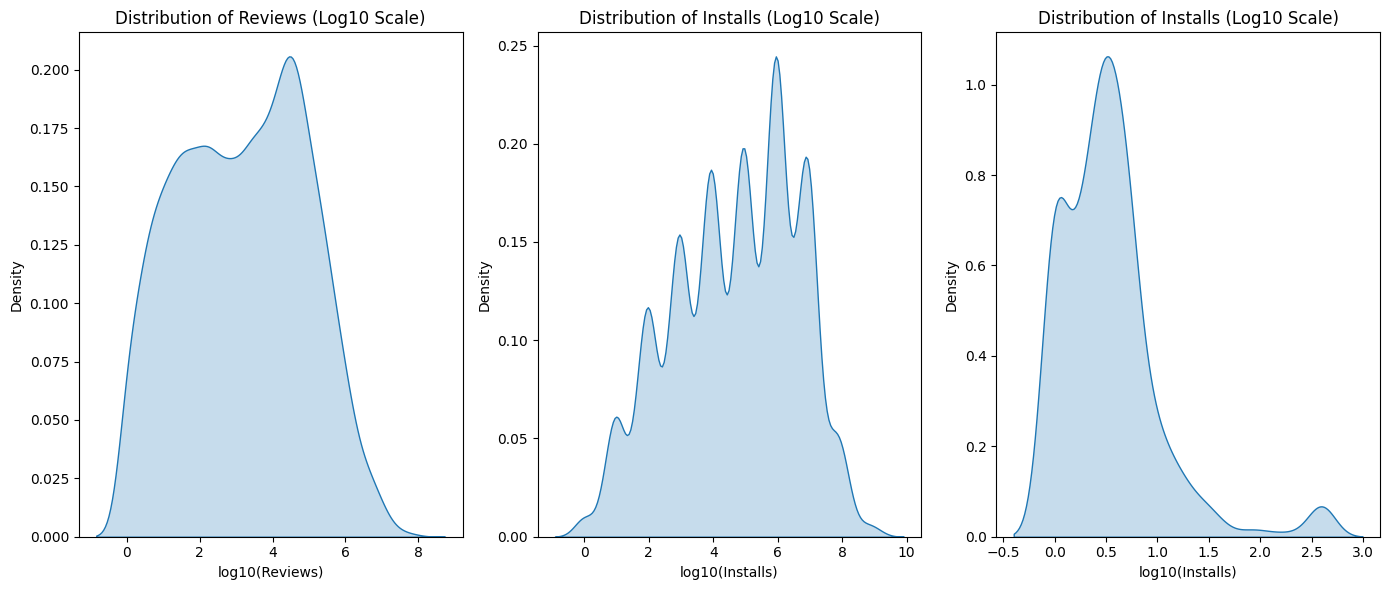

In [49]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 3, 1)
sns.kdeplot(np.log10(df['Reviews'][df['Reviews'] > 0]), fill=True)
plt.title('Distribution of Reviews (Log10 Scale)')
plt.xlabel('log10(Reviews)')
plt.ylabel('Density')

plt.subplot(1, 3, 2)
sns.kdeplot(np.log10(df['Installs'][df['Installs'] > 0]), fill=True)
plt.title('Distribution of Installs (Log10 Scale)')
plt.xlabel('log10(Installs)')
plt.ylabel('Density')

plt.subplot(1, 3, 3)
sns.kdeplot(np.log10(df['Price_$'][df['Price_$'] > 0]), fill=True)
plt.title('Distribution of Installs (Log10 Scale)')
plt.xlabel('log10(Installs)')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

###Kategorik Değişkenlerin Dağılım Grafiği

/tmp/ipython-input-1887380755.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette='viridis')
/tmp/ipython-input-1887380755.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette='viridis')
/tmp/ipython-input-1887380755.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette='viridis')
/tmp/ipython-input-1887380755.py:10: FutureWarning: 

Passing `palette` without

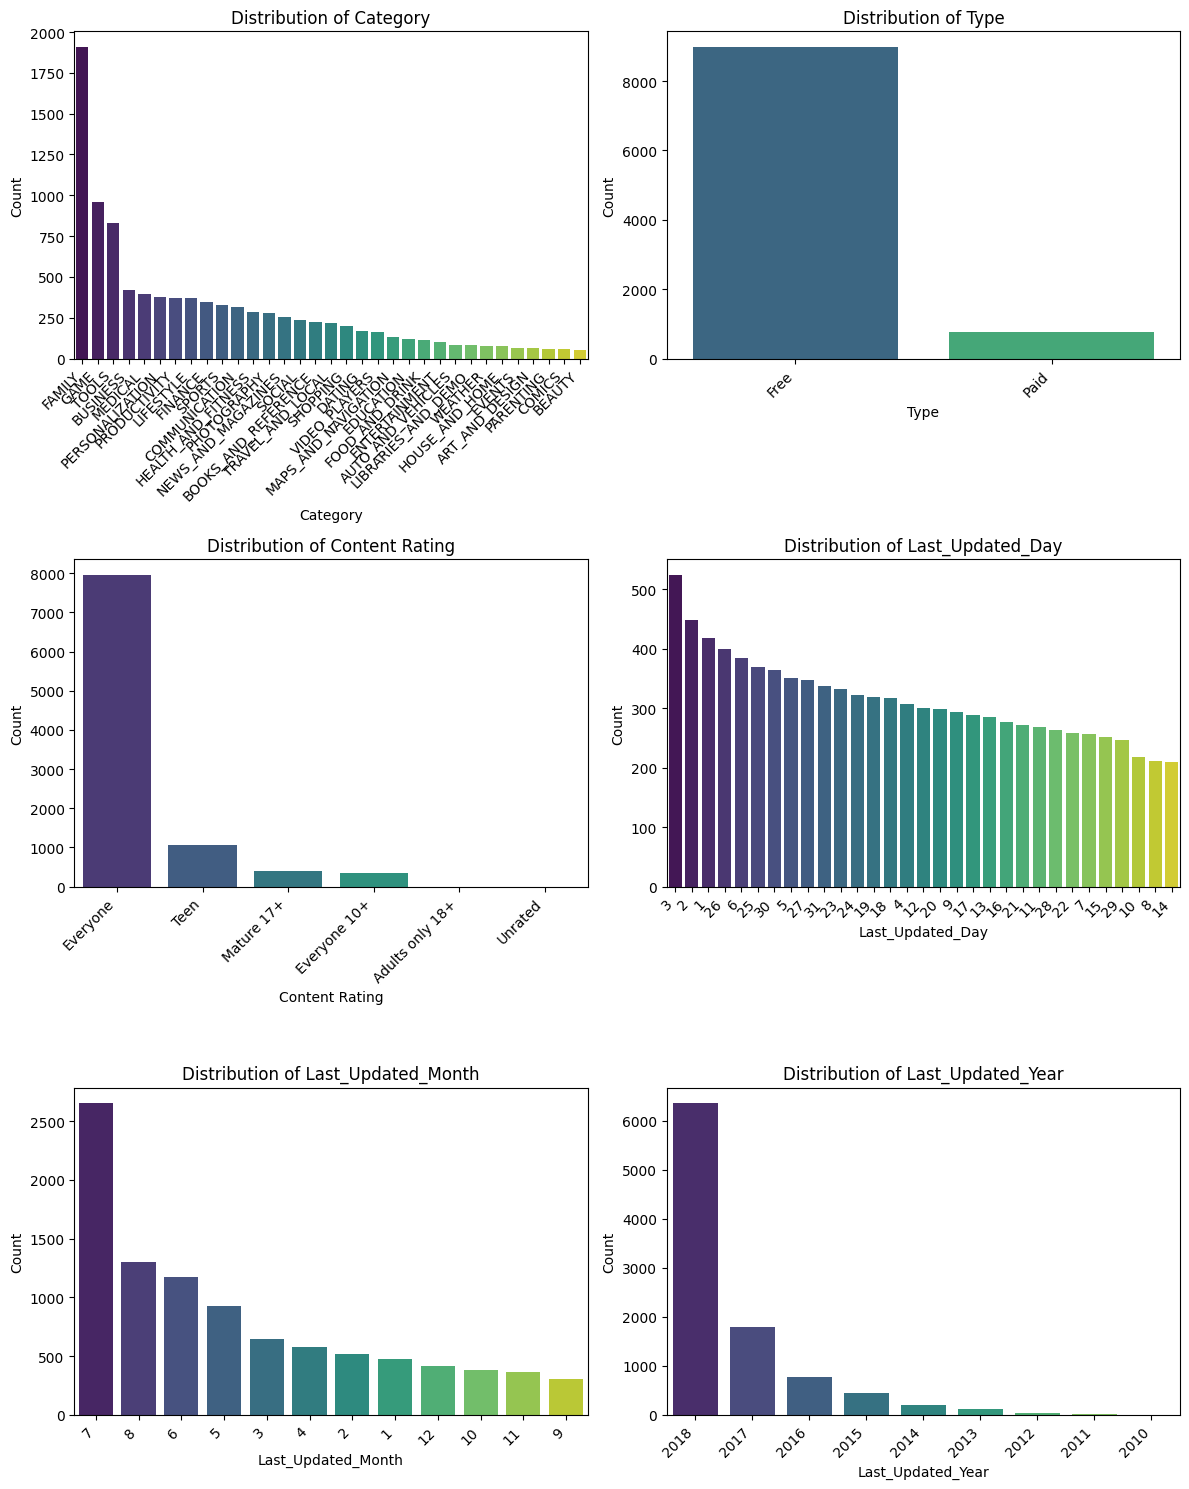

In [50]:
categorical_cols = ['Category', 'Type', 'Content Rating', 'Last_Updated_Day', 'Last_Updated_Month', 'Last_Updated_Year']

num_cols_per_row = 2
num_rows = (len(categorical_cols) + num_cols_per_row - 1) // num_cols_per_row

plt.figure(figsize=(num_cols_per_row * 6, num_rows * 5))

for i, col in enumerate(categorical_cols):
    plt.subplot(num_rows, num_cols_per_row, i + 1)
    sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette='viridis')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [51]:
print(df['Category'].value_counts())

Category
FAMILY                 1909
GAME                    960
TOOLS                   829
BUSINESS                420
MEDICAL                 396
PERSONALIZATION         376
PRODUCTIVITY            374
LIFESTYLE               369
FINANCE                 345
SPORTS                  327
COMMUNICATION           316
HEALTH_AND_FITNESS      288
PHOTOGRAPHY             281
NEWS_AND_MAGAZINES      254
SOCIAL                  239
BOOKS_AND_REFERENCE     222
TRAVEL_AND_LOCAL        219
SHOPPING                202
DATING                  171
VIDEO_PLAYERS           164
MAPS_AND_NAVIGATION     131
EDUCATION               119
FOOD_AND_DRINK          112
ENTERTAINMENT           102
AUTO_AND_VEHICLES        85
LIBRARIES_AND_DEMO       84
WEATHER                  79
HOUSE_AND_HOME           74
EVENTS                   64
ART_AND_DESIGN           64
PARENTING                60
COMICS                   56
BEAUTY                   53
Name: count, dtype: int64


###Kategorilere Göre Uygulamaların İndirilme  Oranları

/tmp/ipython-input-2474091491.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_categories.index, y=top_10_categories.values, palette='viridis')


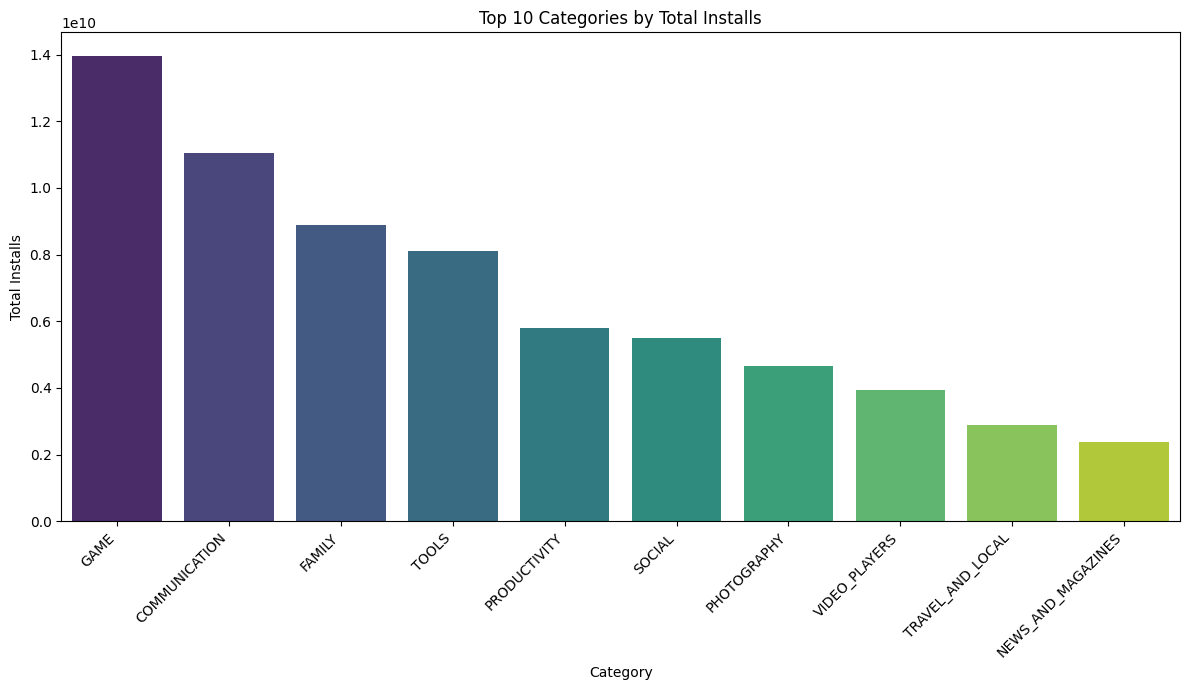

In [52]:
category_installs = df.groupby('Category')['Installs'].sum().sort_values(ascending=False)
top_10_categories = category_installs.head(10)

plt.figure(figsize=(12, 7))
sns.barplot(x=top_10_categories.index, y=top_10_categories.values, palette='viridis')
plt.title('Top 10 Categories by Total Installs')
plt.xlabel('Category')
plt.ylabel('Total Installs')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [53]:
df_app_category = df.groupby(['Category', 'App'])['Installs'].sum().reset_index()
df_app_category = df_app_category.sort_values(by='Installs', ascending=False)

In [54]:
top_5_categories = category_installs.head(5)

####En Çok indirilen Kategorilerin En Çok İndirilen Uygulamaları

In [55]:
top_5_categories = category_installs.head(5)
top_5_category_names = top_5_categories.index

for category_name in top_5_category_names:
    print(f"\nTop 5 Apps in Category: {category_name}")
    df2 = df_app_category[df_app_category['Category'] == category_name]
    df2 = df2.head(5)
    display(df2)


Top 5 Apps in Category: GAME


,Category,App,Installs
4852,GAME,Subway Surfers,1000000000
4707,GAME,Pou,500000000
4659,GAME,My Talking Tom,500000000
4881,GAME,Temple Run 2,500000000
4245,GAME,Candy Crush Saga,500000000



Top 5 Apps in Category: COMMUNICATION


,Category,App,Installs
1146,COMMUNICATION,Skype - free IM & video calls,1000000000
1059,COMMUNICATION,Google Chrome: Fast & Secure,1000000000
1065,COMMUNICATION,Hangouts,1000000000
1100,COMMUNICATION,Messenger – Text and Video Chat for Free,1000000000
1056,COMMUNICATION,Gmail,1000000000



Top 5 Apps in Category: FAMILY


,Category,App,Installs
2698,FAMILY,Google Play Games,1000000000
2149,FAMILY,Candy Crush Saga,500000000
3005,FAMILY,My Talking Tom,500000000
3135,FAMILY,Pou,500000000
3358,FAMILY,Talking Tom Cat 2,100000000



Top 5 Apps in Category: TOOLS


,Category,App,Installs
8920,TOOLS,Google,1000000000
8696,TOOLS,Clean Master- Space Cleaner & Antivirus,500000000
8918,TOOLS,Gboard - the Google Keyboard,500000000
9122,TOOLS,"Security Master - Antivirus, VPN, AppLock, Boo...",500000000
8925,TOOLS,Google Translate,500000000



Top 5 Apps in Category: PRODUCTIVITY


,Category,App,Installs
7507,PRODUCTIVITY,Google Drive,1000000000
7444,PRODUCTIVITY,Dropbox,500000000
7414,PRODUCTIVITY,Cloud Print,500000000
7505,PRODUCTIVITY,Google Calendar,500000000
7552,PRODUCTIVITY,Microsoft Word,500000000



Visualizations for Top 5 Apps in Category: GAME


,Category,App,Installs
4852,GAME,Subway Surfers,1000000000
4707,GAME,Pou,500000000
4659,GAME,My Talking Tom,500000000
4881,GAME,Temple Run 2,500000000
4245,GAME,Candy Crush Saga,500000000


/tmp/ipython-input-2926829217.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='App', y='Installs', data=df2, palette='viridis')


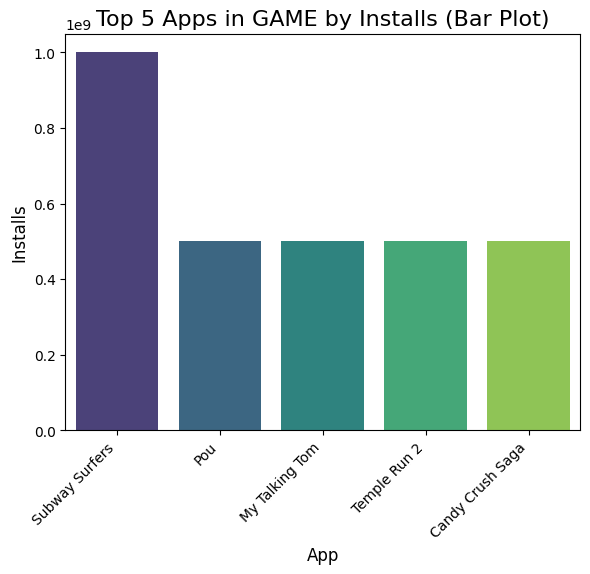


Visualizations for Top 5 Apps in Category: COMMUNICATION


,Category,App,Installs
1146,COMMUNICATION,Skype - free IM & video calls,1000000000
1059,COMMUNICATION,Google Chrome: Fast & Secure,1000000000
1065,COMMUNICATION,Hangouts,1000000000
1100,COMMUNICATION,Messenger – Text and Video Chat for Free,1000000000
1056,COMMUNICATION,Gmail,1000000000


/tmp/ipython-input-2926829217.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='App', y='Installs', data=df2, palette='viridis')


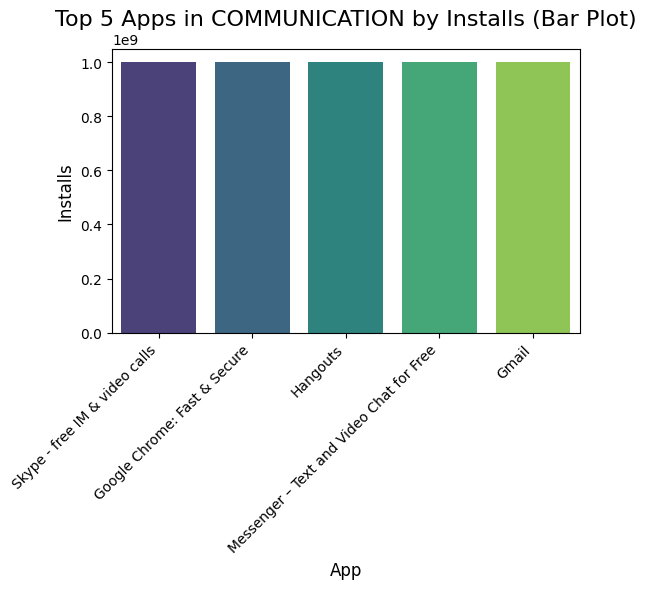


Visualizations for Top 5 Apps in Category: FAMILY


,Category,App,Installs
2698,FAMILY,Google Play Games,1000000000
2149,FAMILY,Candy Crush Saga,500000000
3005,FAMILY,My Talking Tom,500000000
3135,FAMILY,Pou,500000000
3358,FAMILY,Talking Tom Cat 2,100000000


/tmp/ipython-input-2926829217.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='App', y='Installs', data=df2, palette='viridis')


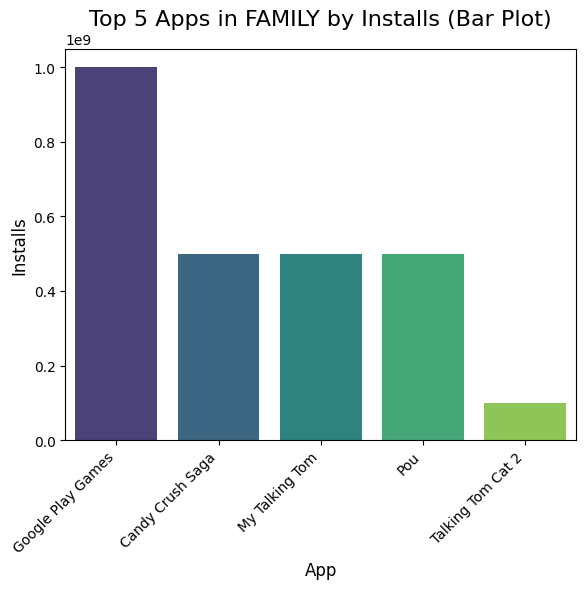


Visualizations for Top 5 Apps in Category: TOOLS


,Category,App,Installs
8920,TOOLS,Google,1000000000
8696,TOOLS,Clean Master- Space Cleaner & Antivirus,500000000
8918,TOOLS,Gboard - the Google Keyboard,500000000
9122,TOOLS,"Security Master - Antivirus, VPN, AppLock, Boo...",500000000
8925,TOOLS,Google Translate,500000000


/tmp/ipython-input-2926829217.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='App', y='Installs', data=df2, palette='viridis')


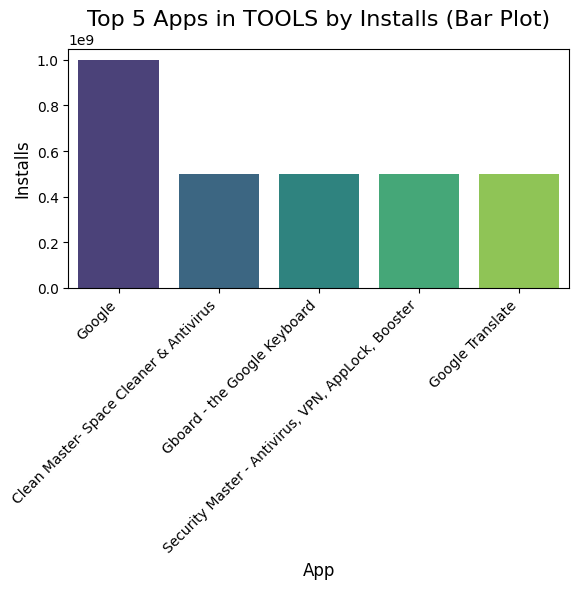


Visualizations for Top 5 Apps in Category: PRODUCTIVITY


,Category,App,Installs
7507,PRODUCTIVITY,Google Drive,1000000000
7444,PRODUCTIVITY,Dropbox,500000000
7414,PRODUCTIVITY,Cloud Print,500000000
7505,PRODUCTIVITY,Google Calendar,500000000
7552,PRODUCTIVITY,Microsoft Word,500000000


/tmp/ipython-input-2926829217.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='App', y='Installs', data=df2, palette='viridis')


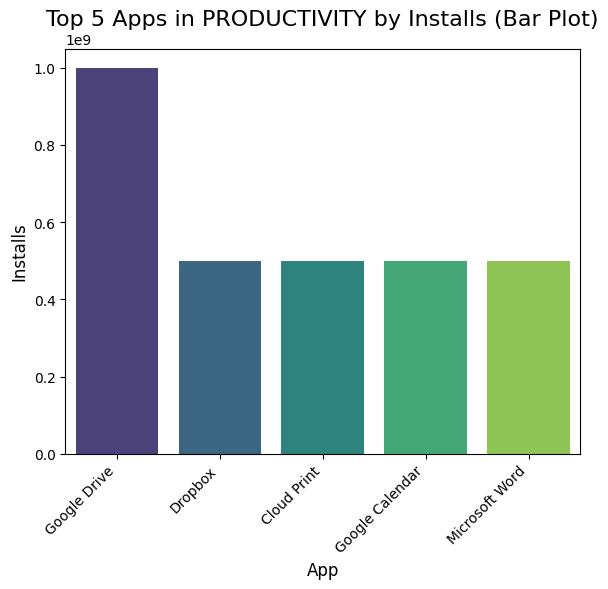

In [56]:
for category_name in top_5_category_names:
    print(f"\nVisualizations for Top 5 Apps in Category: {category_name}")
    df2 = df_app_category[df_app_category['Category'] == category_name]
    df2 = df2.head(5)
    display(df2)
    plt.figure(figsize=(6,6))
    sns.barplot(x='App', y='Installs', data=df2, palette='viridis')
    plt.title(f'Top 5 Apps in {category_name} by Installs (Bar Plot)', fontsize=16)
    plt.xlabel('App', fontsize=12)
    plt.ylabel('Installs', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()


###Kategorilere Göre Uygulamaların Etkileşim (Puan ve Yorum) Oranları

/tmp/ipython-input-4153173589.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_categories.index, y=top_10_categories.values, palette='viridis')


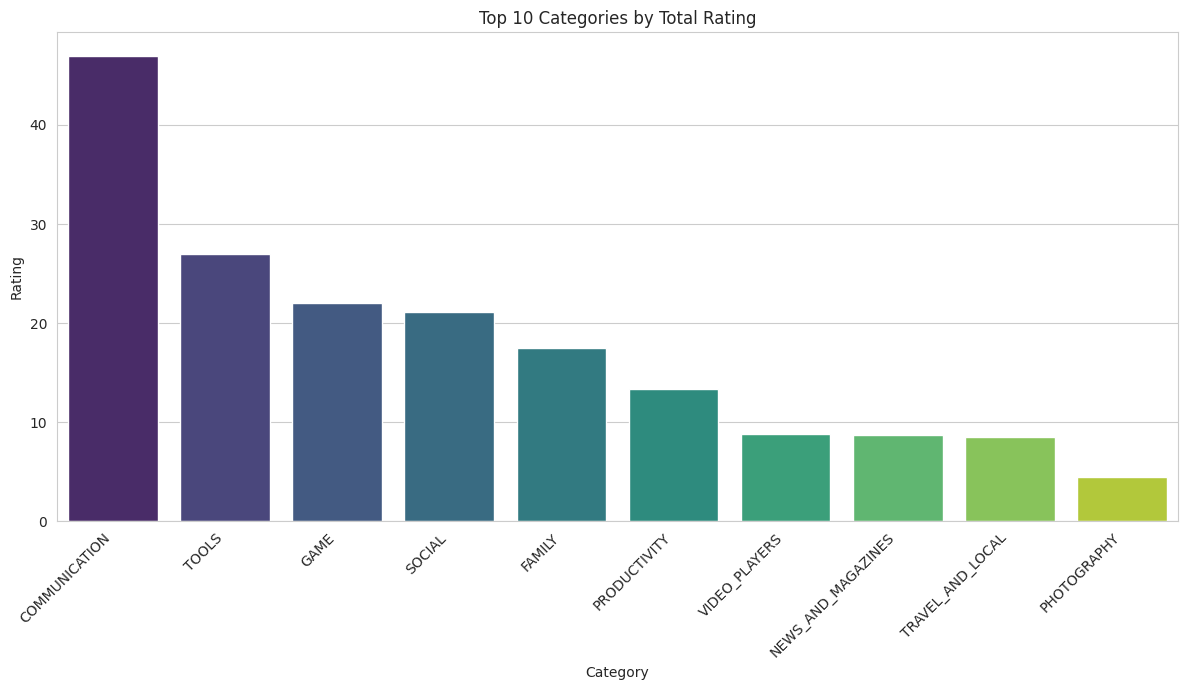

In [64]:
category_rating = df[(df['Reviews'] >= 1000000) & (df['Installs'] >= 500000000)].groupby('Category')['Rating'].sum().sort_values(ascending=False)

top_10_categories = category_rating.head(10)

plt.figure(figsize=(12, 7))
sns.barplot(x=top_10_categories.index, y=top_10_categories.values, palette='viridis')
plt.title('Top 10 Categories by Total Rating')
plt.xlabel('Category')
plt.ylabel('Rating')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

####En Çok Etkileşime Girilen Kategorilerin En Çok Etkileşime Girilen Uygulamaları


--- COMMUNICATION Kategorisi: 500M+ İndirilen En İyi 5 Uygulama ---


,App,Rating,Reviews,Installs
371,Google Duo - High Quality Video Calls,4.6,2083237,500000000
378,UC Browser - Fast Download Private & Secure,4.5,17712922,500000000
3904,WhatsApp Messenger,4.4,69109672,1000000000
342,Viber Messenger,4.3,11334799,500000000
338,Google Chrome: Fast & Secure,4.3,9642995,1000000000


/tmp/ipython-input-3587020419.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='App', y='Rating', data=df2, palette='viridis')


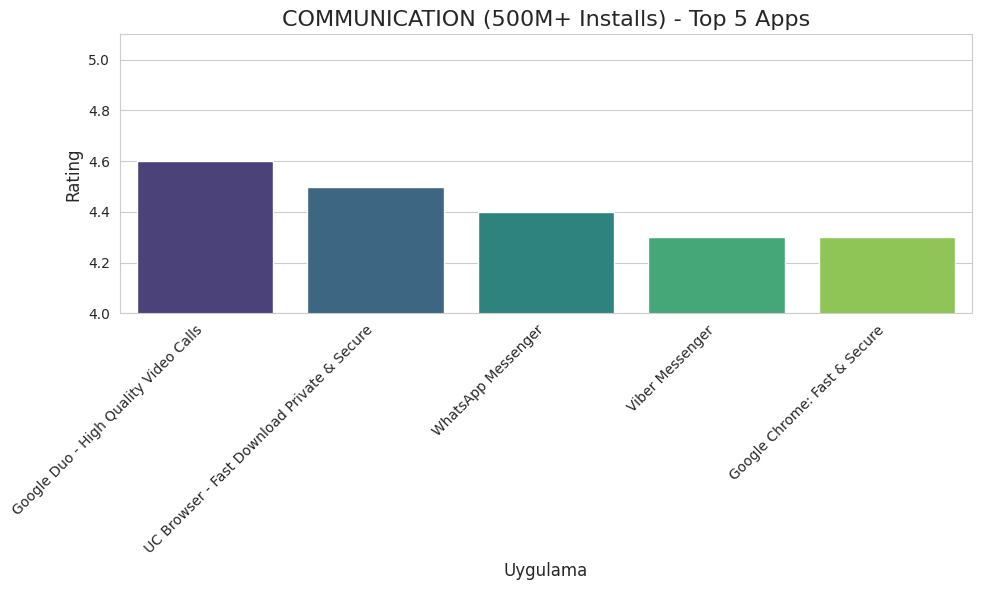


--- TOOLS Kategorisi: 500M+ İndirilen En İyi 5 Uygulama ---


,App,Rating,Reviews,Installs
4005,Clean Master- Space Cleaner & Antivirus,4.7,42916526,500000000
7536,"Security Master - Antivirus, VPN, AppLock, Boo...",4.7,24900999,500000000
3255,SHAREit - Transfer & Share,4.6,7790693,500000000
3234,Google,4.4,8033493,1000000000
3907,Google Translate,4.4,5741684,500000000


/tmp/ipython-input-3587020419.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='App', y='Rating', data=df2, palette='viridis')


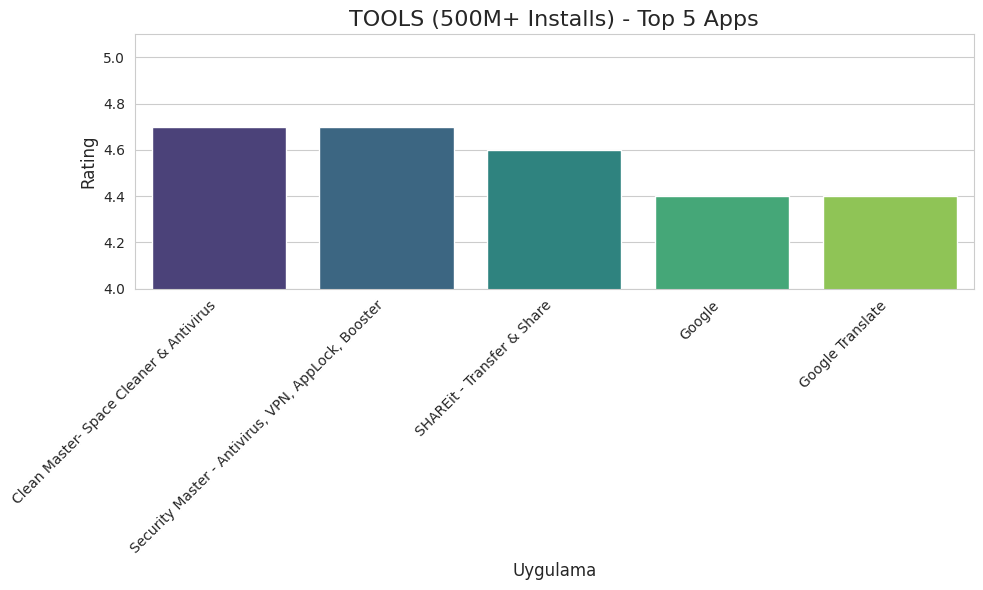


--- GAME Kategorisi: 500M+ İndirilen En İyi 5 Uygulama ---


,App,Rating,Reviews,Installs
1750,Subway Surfers,4.5,27724094,1000000000
1722,My Talking Tom,4.5,14891223,500000000
1705,Candy Crush Saga,4.4,22428456,500000000
1702,Pou,4.3,10485334,500000000
4041,Temple Run 2,4.3,8116142,500000000


/tmp/ipython-input-3587020419.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='App', y='Rating', data=df2, palette='viridis')


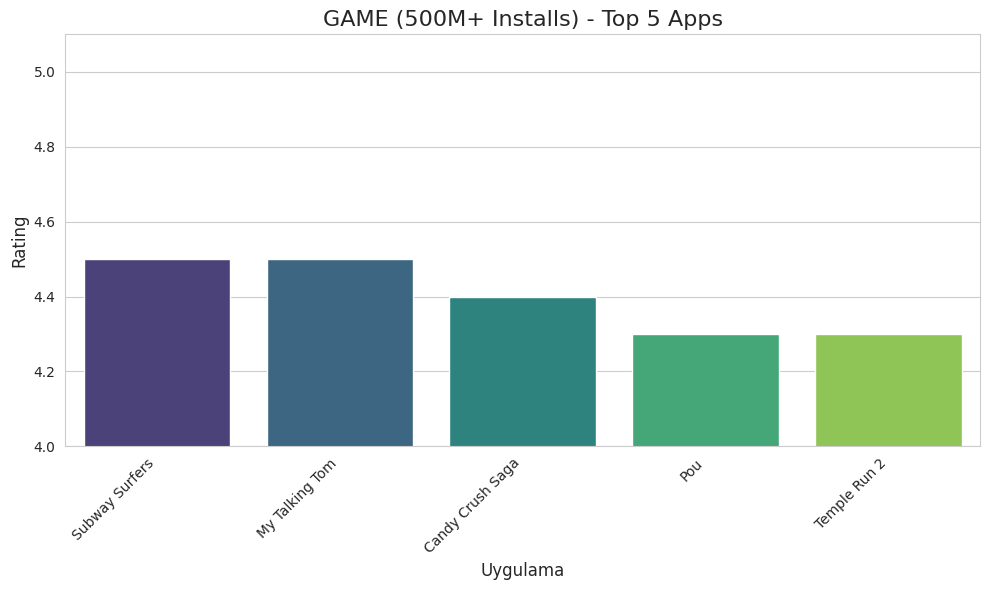


--- SOCIAL Kategorisi: 500M+ İndirilen En İyi 5 Uygulama ---


,App,Rating,Reviews,Installs
3909,Instagram,4.5,66509917,1000000000
4105,Facebook Lite,4.3,8595964,500000000
2554,Google+,4.2,4831125,1000000000
2544,Facebook,4.1,78158306,1000000000
2603,Snapchat,4.0,17014705,500000000


/tmp/ipython-input-3587020419.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='App', y='Rating', data=df2, palette='viridis')


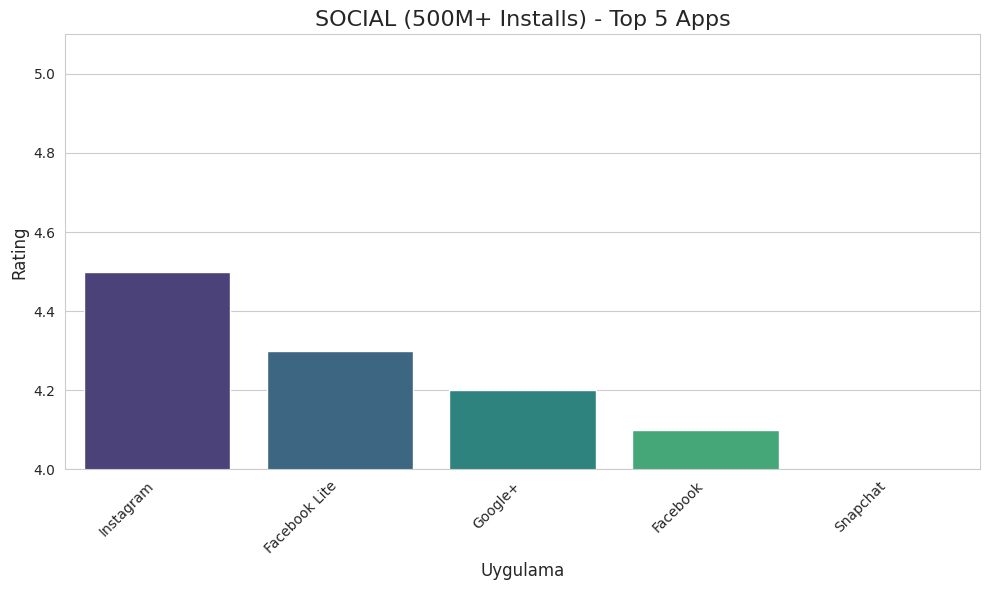


--- FAMILY Kategorisi: 500M+ İndirilen En İyi 5 Uygulama ---


,App,Rating,Reviews,Installs
3888,My Talking Tom,4.5,14885236,500000000
3994,Candy Crush Saga,4.4,22419455,500000000
3879,Pou,4.3,10483141,500000000
5856,Google Play Games,4.3,7168735,1000000000


/tmp/ipython-input-3587020419.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='App', y='Rating', data=df2, palette='viridis')


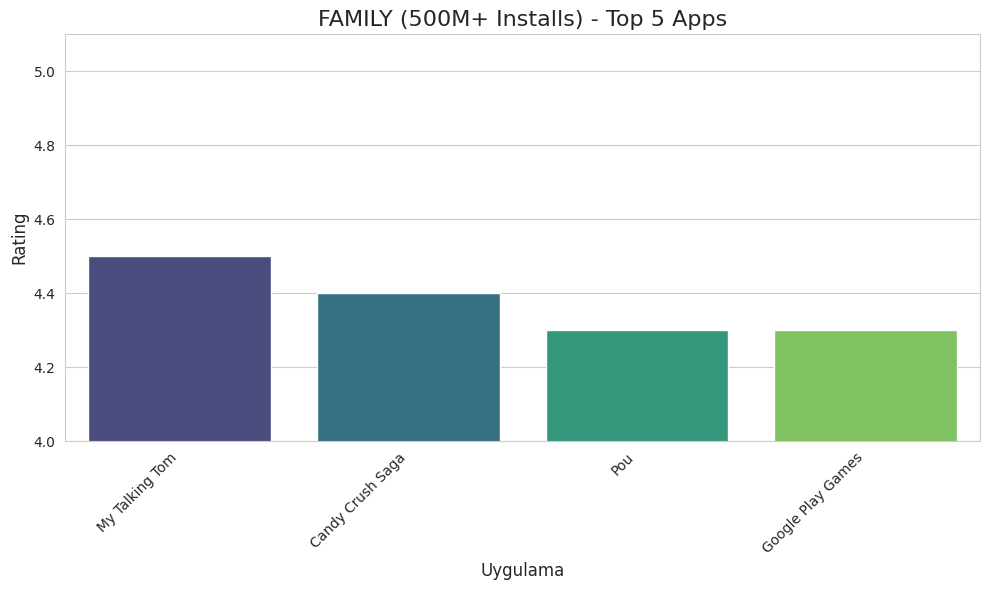

In [65]:
category_rating = df[(df['Reviews'] >= 1000000) & (df['Installs'] >= 500000000)].groupby('Category')['Rating'].sum().sort_values(ascending=False)

top_5_categories = category_rating.head(5)
top_5_category_names = top_5_categories.index.tolist()

for category_name in top_5_category_names:
    print(f"\n--- {category_name} Kategorisi: 500M+ İndirilen En İyi 5 Uygulama ---")

    df2 = df[(df['Category'] == category_name) &
             (df['Reviews'] >= 1000000) &
             (df['Installs'] >= 500000000)]

    df2 = df2.sort_values(by=['Rating', 'Reviews'], ascending=False).head(5)

    if df2.empty:
        print("Bu kategoride 500 Milyon+ indirilmiş ve yüksek yorumlu uygulama bulunamadı.")
        continue

    display(df2[['App', 'Rating', 'Reviews', 'Installs']])

    plt.figure(figsize=(10, 6))
    sns.barplot(x='App', y='Rating', data=df2, palette='viridis')

    plt.title(f'{category_name} (500M+ Installs) - Top 5 Apps', fontsize=16)
    plt.xlabel('Uygulama', fontsize=12)
    plt.ylabel('Rating', fontsize=12)

    plt.ylim(4.0, 5.1)

    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.tight_layout()
    plt.show()

###Puan (Rating) ve Yorum Sayısı (Reviews) İlişkisi Analizi

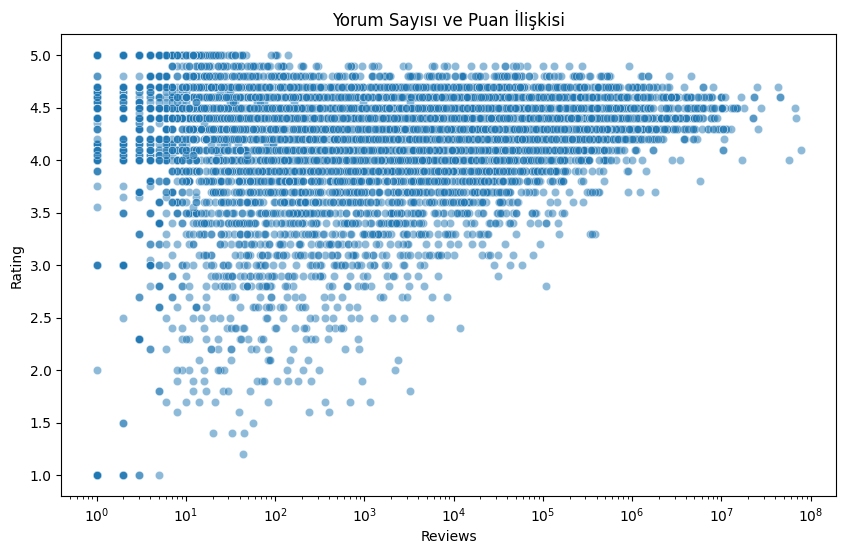

In [59]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Reviews', y='Rating', data=df, alpha=0.5)
plt.title('Yorum Sayısı ve Puan İlişkisi')
plt.xscale('log')
plt.show()

In [60]:
#Yüksek puanlı ancak yorumu 50'yi geçmeyen uygulamalar / Güvenilirlik Testi

supheli_uygulamalar = df[(df['Rating'] > 4.5) & (df['Reviews'] < 50)]

ortalama_indirme = supheli_uygulamalar['Installs'].median()

print(ortalama_indirme)

100.0


Veri seti üzerinde yapılan görselleştirme (Scatter Plot) ve incelemeler sonucunda şu gruplamalar tespit edilmiştir:

* **Düşük Puan & Düşük Yorum Sayısı:** Kullanıcılar tarafından beğenilmeyen ve etkileşimi zayıf olan uygulamalar.
* **Orta Puan & Orta Yorum Sayısı:** Standart performans gösteren ve belirli bir kitleye ulaşmış uygulamalar.
* **Yüksek Puan & Yüksek Yorum Sayısı:** Geniş kitlelerce indirilmiş, popülaritesi yüksek ve kalitesi binlerce kullanıcı tarafından doğrulanmış güvenilir uygulamalar.
* **Yüksek Puan & Düşük Yorum Sayısı:** *Aykırı (Outlier) Grup.*
Bu  grupta yer alan uygulamaların, aslında **indirme sayılarının (Installs) çok düşük olduğu** görülmüştür. Uygulama henüz geniş bir kitleye ulaşmadığı ve çok az sayıda kişi (muhtemelen sadece yakın çevre veya çok küçük bir örneklem) tarafından oylandığı için puanı yapay olarak yüksek kalmıştır. Yani **"Küçük Örneklem Yanlılığı" (Small Sample Size Bias)** vardır; bu puanlar uygulamanın genel kalitesini değil, henüz yeterince test edilmediğini gösterir.

###Kategori Bazlı Değerlendirme (Category vs Rating)

/tmp/ipython-input-838119112.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y='Rating', data=df, palette='viridis')


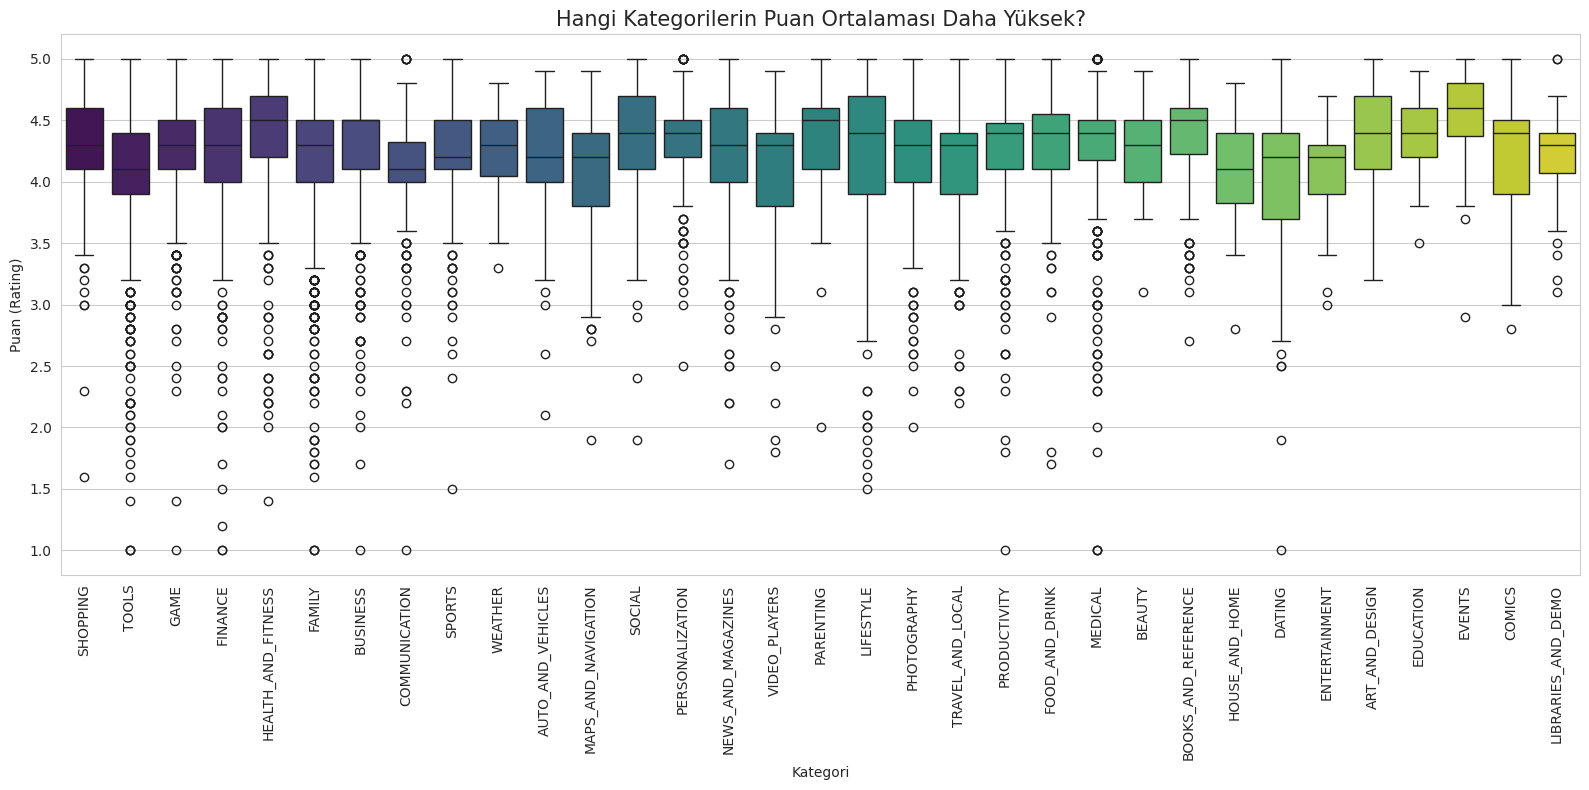

In [61]:
sns.set_style("whitegrid")

plt.figure(figsize=(16, 8))
sns.boxplot(x='Category', y='Rating', data=df, palette='viridis')

plt.xticks(rotation=90)
plt.title('Hangi Kategorilerin Puan Ortalaması Daha Yüksek?', fontsize=15)
plt.ylabel('Puan (Rating)')
plt.xlabel('Kategori')
plt.tight_layout()
plt.show()


**Genel Memnuniyet Yüksek:** Hemen hemen tüm kategorilerin medyan (ortanca) puanı 4.0 barajının üzerindedir. Bu, market genelinde kullanıcıların uygulamalardan çoğunlukla memnun olduğunu gösterir.

**En Tutarlı Kategoriler:** Özellikle "Events" kategorisi; kutu boyunun kısalığı (düşük varyans), medyan değerinin yüksekliği ve aykırı değer azlığı ile en tutarlı ve başarılı kategorilerden biri olarak öne çıkar. Kullanıcılar bu kategoride ne bulacağını bilir ve genelde aradığını bulur.

**Yüksek Riskli Kategoriler:** Tools, Finance, Family, Medical, Health and Fitness, Business gibi kategorilerin medyan puanları yüksek olsa da, alt tarafta oluşan yoğun aykırı değerler (outliers) dikkat çekicidir. Bu durum, bu kategorilerde çok kaliteli uygulamaların yanı sıra, "çöp" (kalitesiz/spam) niteliğinde çok sayıda uygulama olduğunu ve kalite standart sapmasının yüksek olduğunu gösterir.

----
###Ücret Politikası Etkisi (Paid vs Free)

/tmp/ipython-input-4241974811.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Type', y='Rating', data=df, palette='Set2')


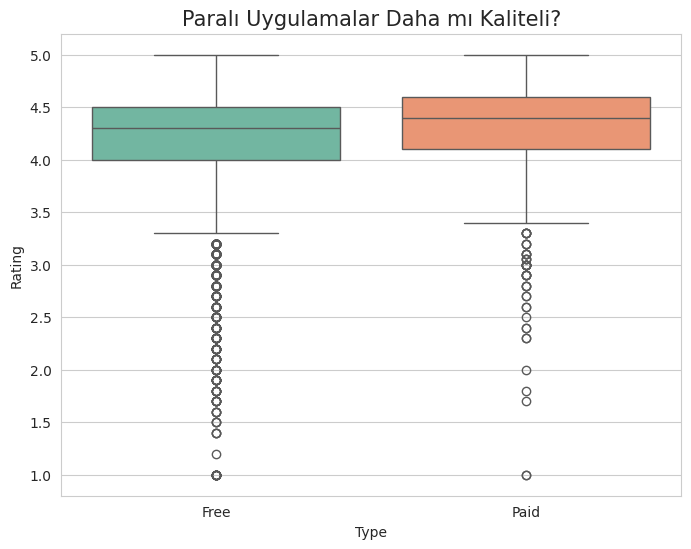

In [62]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Type', y='Rating', data=df, palette='Set2')

plt.title('Paralı Uygulamalar Daha mı Kaliteli?', fontsize=15)
plt.show()

**İnsanlar Paralı Uygulamalardan Daha Memnun Kalıyor:**

Grafiğe bakıldığında, ücretli (Paid) uygulamaların kullanıcı memnuniyetinin daha yüksek olduğu görülmektedir.

- Ücretli uygulamaların medyan çizgisi, ücretsizlere göre daha yukarıdadır.
- Kutu (IQR) konumu daha yüksek bir puan aralığına yerleşmiştir.
- Ücretsiz (Free) uygulamalarda 1.0 puana kadar inen yoğun bir aykırı değer (outlier) kümesi varken, ücretli uygulamalarda bu "çok kötü" uygulama sayısı belirgin şekilde daha azdır.

----
###Hedef Kitle Etkisi (Content Rating)

/tmp/ipython-input-3540541610.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Content Rating', y='Rating', data=df, palette='pastel')


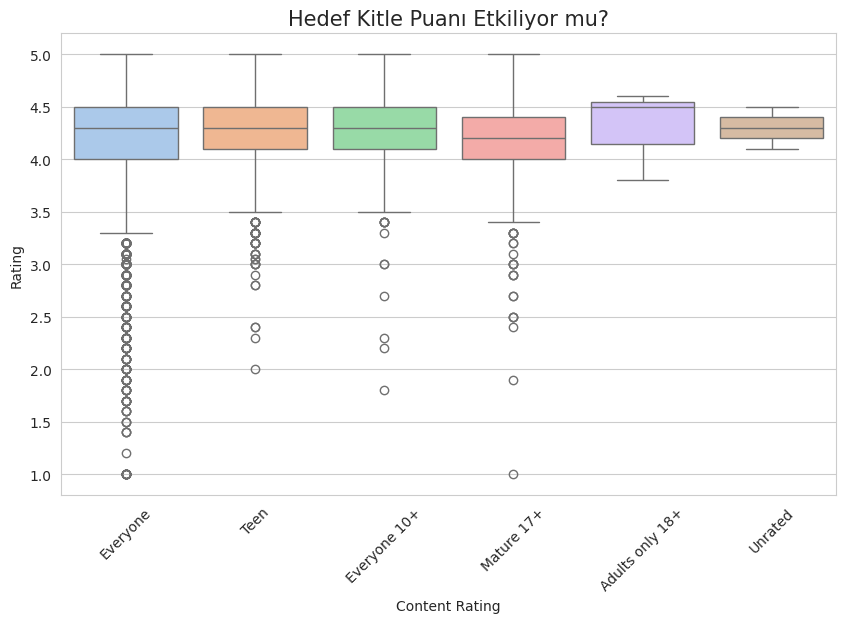

In [63]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Content Rating', y='Rating', data=df, palette='pastel')

plt.title('Hedef Kitle Puanı Etkiliyor mu?', fontsize=15)
plt.xticks(rotation=45)
plt.show()

**Veri Yanılgısı (18+ ve Unrated):** "Adults only 18+" ve "Unrated" kategorileri grafikte mükemmel görünse de, bu kategorilerdeki örneklem sayısı (veri adedi) istatistiksel çıkarım yapmak için yetersizdir. Bu yükseklik genel başarıyı değil, az sayıdaki verinin tesadüfi başarısını yansıtır.

**"Herkes" (Everyone) Tuzağı:** "Everyone" kategorisi en geniş kitleye hitap ettiği için, memnun edilmesi en zor gruptur. Bu nedenle aykırı değer sayısı çok fazladır ve dağılım geniştir.

`Sonuç:` Diğer kategorilerin medyan değerleri birbirine yakın olsa da, kitle özelleştikçe (Teen, Mature 17+) puanlardaki tutarlılık artmaktadır.
Bu yüzden hedef kitlenin puan ortalaması üzerinde radikal bir fark yaratmasa da, puanın tutarlılığı ve kalitenin korunması üzerinde direkt etkisi vardır.